In [138]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

#from sktime.datasets import load_UCR_UEA_dataset
from tslearn.datasets import UCR_UEA_datasets

#1d interpolation
from scipy.interpolate import interp1d

In [139]:
#list all the multi-multivariate time series datasets
multivariate_dataset_names = UCR_UEA_datasets().list_multivariate_datasets()

In [140]:
print(multivariate_dataset_names)

['ArticularyWordRecognition', 'AtrialFibrillation', 'BasicMotions', 'CharacterTrajectories', 'Cricket', 'DuckDuckGeese', 'EigenWorms', 'Epilepsy', 'EthanolConcentration', 'ERing', 'FaceDetection', 'FingerMovements', 'HandMovementDirection', 'Handwriting', 'Heartbeat', 'InsectWingbeat', 'JapaneseVowels', 'Libras', 'LSST', 'MotorImagery', 'NATOPS', 'PenDigits', 'PEMS-SF', 'Phoneme', 'RacketSports', 'SelfRegulationSCP1', 'SelfRegulationSCP2', 'SpokenArabicDigits', 'StandWalkJump', 'UWaveGestureLibrary']


In [141]:
dataset_name = 'Cricket'
X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset(dataset_name)

In [142]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((108, 1197, 6), (108,), (72, 1197, 6), (72,))

In [143]:
y_test

array(['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '2.0', '2.0', '2.0',
       '2.0', '2.0', '2.0', '3.0', '3.0', '3.0', '3.0', '3.0', '3.0',
       '4.0', '4.0', '4.0', '4.0', '4.0', '4.0', '5.0', '5.0', '5.0',
       '5.0', '5.0', '5.0', '6.0', '6.0', '6.0', '6.0', '6.0', '6.0',
       '7.0', '7.0', '7.0', '7.0', '7.0', '7.0', '8.0', '8.0', '8.0',
       '8.0', '8.0', '8.0', '9.0', '9.0', '9.0', '9.0', '9.0', '9.0',
       '10.0', '10.0', '10.0', '10.0', '10.0', '10.0', '11.0', '11.0',
       '11.0', '11.0', '11.0', '11.0', '12.0', '12.0', '12.0', '12.0',
       '12.0', '12.0'], dtype='<U4')

In [144]:
y_train

array(['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0',
       '2.0', '2.0', '2.0', '2.0', '2.0', '2.0', '2.0', '2.0', '2.0',
       '3.0', '3.0', '3.0', '3.0', '3.0', '3.0', '3.0', '3.0', '3.0',
       '4.0', '4.0', '4.0', '4.0', '4.0', '4.0', '4.0', '4.0', '4.0',
       '5.0', '5.0', '5.0', '5.0', '5.0', '5.0', '5.0', '5.0', '5.0',
       '6.0', '6.0', '6.0', '6.0', '6.0', '6.0', '6.0', '6.0', '6.0',
       '7.0', '7.0', '7.0', '7.0', '7.0', '7.0', '7.0', '7.0', '7.0',
       '8.0', '8.0', '8.0', '8.0', '8.0', '8.0', '8.0', '8.0', '8.0',
       '9.0', '9.0', '9.0', '9.0', '9.0', '9.0', '9.0', '9.0', '9.0',
       '10.0', '10.0', '10.0', '10.0', '10.0', '10.0', '10.0', '10.0',
       '10.0', '11.0', '11.0', '11.0', '11.0', '11.0', '11.0', '11.0',
       '11.0', '11.0', '12.0', '12.0', '12.0', '12.0', '12.0', '12.0',
       '12.0', '12.0', '12.0'], dtype='<U4')

In [145]:
#encode the labels
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

In [146]:
#interpolate data
length = 100
def interpolate(X, length):
    X_interpolated = []
    for i in range(X.shape[0]):
        x = np.linspace(0, 1, X.shape[1])
        f = interp1d(x, X[i], axis=0)
        xnew = np.linspace(0, 1, length)
        ynew = f(xnew)
        X_interpolated.append(ynew)
    return np.array(X_interpolated)

In [147]:
X_train = interpolate(X_train, length)
X_test = interpolate(X_test, length)

In [148]:
#convert to torch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()

In [149]:
# # #normalize data
# X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
# X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())

In [150]:
#number of classes
num_classes = len(np.unique(y_train))
print(f'Number of classes: {num_classes}')

Number of classes: 12


In [151]:
#Datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
#DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [152]:
X_train.max(), X_train.min(), X_test.max(), X_test.min()

(tensor(9.9137), tensor(-5.9930), tensor(8.6509), tensor(-6.5146))

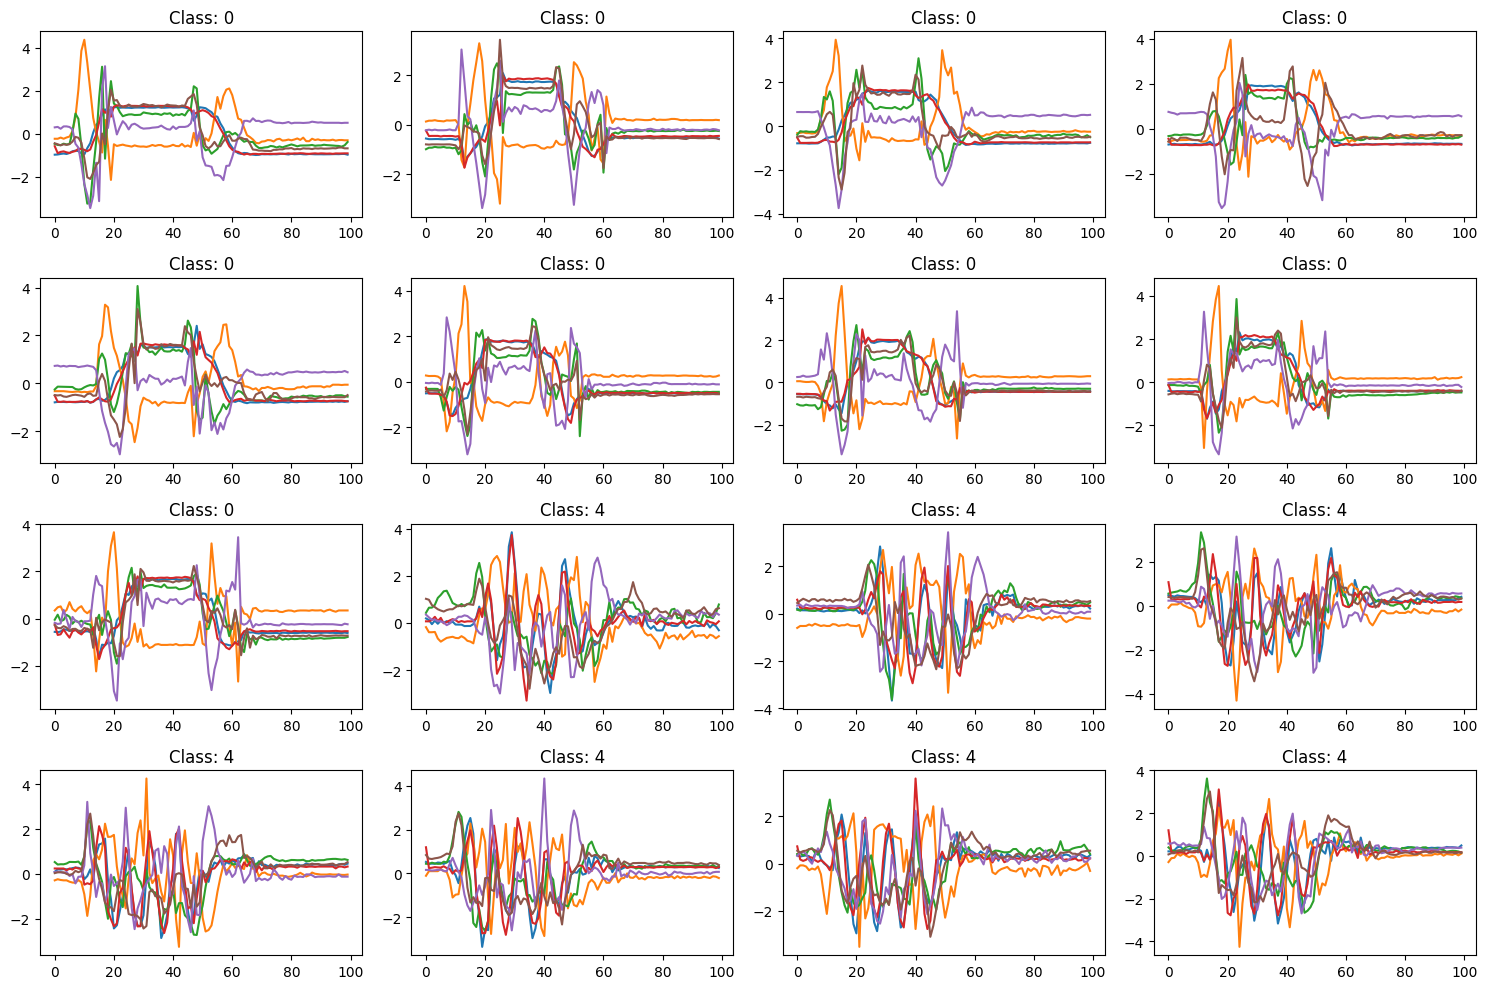

In [153]:
#plot 4x4 grid of time series
fig, axs = plt.subplots(4, 4, figsize=(15, 10))
for i in range(4):
    for j in range(4):
        axs[i, j].plot(X_train[i*4+j, :, :])
        axs[i, j].set_title(f'Class: {y_train[i*4+j]}')
#tight layout
plt.tight_layout()
plt.show()

In [154]:
#model
class CNN(nn.Module):
    def __init__(self, in_channel, num_class):
        super(CNN, self).__init__()
        self.sequential = nn.Sequential(
            nn.Conv1d(in_channel, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            #flatten
            nn.Flatten(),
            nn.LazyLinear(out_features=128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.LazyLinear(out_features=num_class)
        )
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.sequential(x)
        return x
#LSTM
class LSTM(nn.Module):
    def __init__(self, in_channel, num_class):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=in_channel, hidden_size=128, num_layers=3, batch_first=True)
        self.sequential = nn.Sequential(
            nn.LazyLinear(out_features=128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.LazyLinear(out_features=num_class)
        )
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    def forward(self, x):
        #set initial states
        h0 = torch.zeros(3, x.size(0), 128).to(self.device)
        c0 = torch.zeros(3, x.size(0), 128).to(self.device)
        #forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        #decode the hidden state of the last time step
        out = self.sequential(out[:, -1, :])
        return out

In [155]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


In [156]:
in_channels = X_train.shape[-1]
num_classes = len(np.unique(y_train))
#model = CNN(in_channels, num_classes).to(device)
model = LSTM(in_channels, num_classes).to(device)

In [157]:
#feed a sample through the model
for data, target in train_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    print(output.shape)
    break

torch.Size([32, 12])


In [158]:
#optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
#loss function
criterion = nn.CrossEntropyLoss()

In [159]:
#training
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        #forward pass
        output = model(data)
        #loss
        loss = criterion(output, target)
        #backward pass
        optimizer.zero_grad()
        loss.backward()
        #update weights
        optimizer.step()
    if (epoch+1) % 100 == 0:
        print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

Epoch: 100/500, Loss: 0.0064
Epoch: 200/500, Loss: 0.0010
Epoch: 300/500, Loss: 0.0003
Epoch: 400/500, Loss: 0.0026
Epoch: 500/500, Loss: 0.0001


In [160]:
#testing
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    print(f'Accuracy: {100*correct/total:.2f}%')

Accuracy: 87.50%


In [161]:
#CNN
#normalization reduces accuracy!!!
#Interpolating to let's say 100 reduces caculation time without impacting accuracy.
#Trainging too much reduces accuracy.